In [1]:
!pip3 install torchgan

In [0]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
# Pytorch and Torchvision Imports
import torch
import torchvision
from torch.optim import Adam
import torch.nn as nn
from torch.nn import functional as F
import torch.utils.data as data
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision.utils as vutils
# Torchgan Imports
from torchgan.losses import MinimaxGeneratorLoss, MinimaxDiscriminatorLoss
import torchgan
from torchgan.layers import SpectralNorm2d, SelfAttention2d, ResidualBlock2d
from torchgan.models import Generator, Discriminator
from torchgan.losses import WassersteinGeneratorLoss, WassersteinDiscriminatorLoss, WassersteinGradientPenalty
from torchgan.trainer import Trainer

from google.colab.patches import cv2_imshow
import cv2


In [3]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def apple_loader(data_size=512):
  for root, dirs, files in os.walk("../content/drive/My Drive/apples/images/"):
      res = np.zeros((data_size, 3,128,128))
      ex_count = 0
      for i, file in enumerate(files):
        
     
        if file.endswith(".jpg"):
             image=cv2.imread(root+file)
             try:
                image.resize(3,128,128)
                image = image/ 127.5 - 1.
                res[i,:,:,:] = image
             except AttributeError:
                ex_count+=1
                pass
             
        if i > data_size-2 : 
          print(ex_count)
          print(len(files))
          features = torch.from_numpy(res)
          features = features.float()
          targets = torch.ones(data_size)
          train_tensor = data.TensorDataset(features, targets)
          train_loader = data.DataLoader(train_tensor, batch_size=16, shuffle=True)
          return train_loader

images/epoch1_generator.png


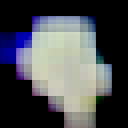

images/epoch2_generator.png


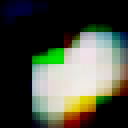

images/epoch3_generator.png


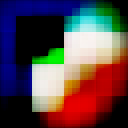

images/epoch4_generator.png


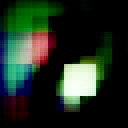

images/epoch5_generator.png


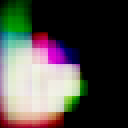

images/epoch6_generator.png


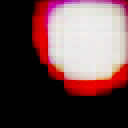

images/epoch7_generator.png


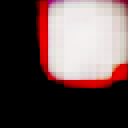

images/epoch8_generator.png


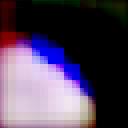

images/epoch9_generator.png


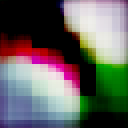

images/epoch10_generator.png


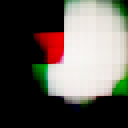

images/epoch11_generator.png


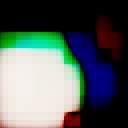

images/epoch12_generator.png


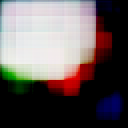

images/epoch13_generator.png


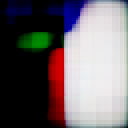

images/epoch14_generator.png


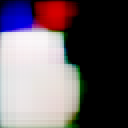

images/epoch15_generator.png


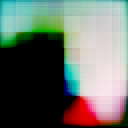

images/epoch16_generator.png


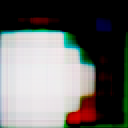

images/epoch17_generator.png


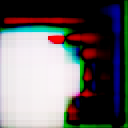

images/epoch18_generator.png


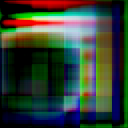

images/epoch19_generator.png


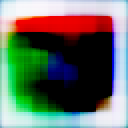

images/epoch20_generator.png


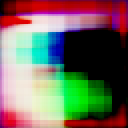

images/epoch21_generator.png


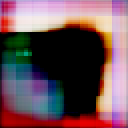

images/epoch22_generator.png


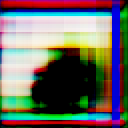

In [5]:
for i in range(1,23):
  path = 'images/epoch' + str(i) + '_generator.png'
  print(path)
  sample = cv2.imread(path)
  sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
  cv2_imshow(sample)

In [0]:
# sample = cv2.imread('images/epoch1_generator.png')
# sample.shape

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    # Use deterministic cudnn algorithms
    torch.backends.cudnn.deterministic = True
    epochs = 20
else:
    device = torch.device("cpu")
    epochs = 10

print("Device: {}".format(device))
print("Epochs: {}".format(epochs))

Device: cuda:0
Epochs: 20


In [0]:
class ResDown(nn.Module):
  def __init__(self, input_channels, output_channels):
    super(ResDown, self).__init__()
   
    self.skip = nn.Sequential(
                  nn.Conv2d(input_channels, output_channels, 1),
                  nn.AvgPool2d(2))
    self.model = nn.Sequential(
                nn.LeakyReLU(0.2),
                nn.Conv2d(input_channels, output_channels, 3,1,1),
                nn.LeakyReLU(0.2),
                nn.Conv2d(output_channels, output_channels, 3,1,1),
                nn.AvgPool2d(2))
  def forward(self, x):
    main = self.model(x)
    skip = self.skip(x)
    out = torch.add(skip, main)
    return out

In [0]:
class BigGanDiscriminator(Discriminator):
    def __init__(self, chn=64):
        super(BigGanDiscriminator, self).__init__(3, 'none')
        self.pre_conv = nn.Sequential(SpectralNorm2d(nn.Conv2d(3, chn, 3,1,1)),
                                      nn.ReLU(),
                                      SpectralNorm2d(nn.Conv2d(chn, chn, 3,1,1)),
                                      nn.AvgPool2d(2))
        self.pre_skip = SpectralNorm2d(nn.Conv2d(3, chn, 1))

        self.conv = nn.Sequential(ResDown(chn, chn),
                                  SelfAttention2d(chn),
                                  ResDown(chn, 2*chn),    
                                  ResDown(2*chn, 4*chn),
                                  ResDown(4*chn, 8*chn),
                                  ResDown(8*chn, 16*chn))
        self.res_layer = ResidualBlock2d([16*chn, 16*chn], [3], [1],[1])
        self.linear = SpectralNorm2d(nn.Linear(16*chn, 1))

        self.last = nn.LeakyReLU(0.2)
    def forward(self, x):
      out = self.pre_conv(x)
      out = out + self.pre_skip(F.avg_pool2d(x, 2))
      out = self.conv(out)
      out = self.res_layer(out)
      out = out.view(out.size(0), out.size(1), -1)
      out = out.sum(2)
      out = self.linear(out)
      out = self.last(out)
      
      return out

In [0]:
class ResUp(nn.Module):
  def __init__(self, input_channels, output_channels):
    super(ResUp, self).__init__()
    self.skip =  nn.Conv2d(input_channels , output_channels, 1)
    self.model_1 = nn.Sequential(nn.BatchNorm2d(input_channels), nn.LeakyReLU(0.2))
    self.model_2 = nn.Sequential(              
                nn.Conv2d(input_channels, output_channels , 3,1,1),
                nn.BatchNorm2d(output_channels), nn.LeakyReLU(0.2),
                nn.Conv2d(output_channels, output_channels, 3,1,1))
  def forward(self, x):
    main = self.model_1(x)
 
    main = F.upsample(main, scale_factor=2)
   
    main = self.model_2(main)
    skip = F.upsample(self.skip(x), scale_factor=2)
    out = torch.add(main, skip)
    return out


In [0]:
class BigGanGenerator(Generator):
    def __init__(self, chn=64):
        super(BigGanGenerator, self).__init__(1, 'none')
        self.chn = chn
        
        self.linear = SpectralNorm2d(nn.Linear(1, 4 * 4 * 16 * chn))
        self.conv = nn.Sequential(ResUp(16*chn, 16*chn),
                               
                                ResUp(16*chn, 8*chn),
                                
                                ResUp(8*chn, 4*chn),
                                
                                ResUp(4*chn, 2*chn),
                                
                                SelfAttention2d(2*chn),
                                ResUp(2*chn, chn)
                              
                                )
        self.last = nn.Sequential(nn.BatchNorm2d(chn), nn.LeakyReLU(0.2),
                nn.Conv2d(chn, 3, 1), nn.Tanh())
    def forward(self, x):

        out = self.linear(x)
        out = out.view(-1, 16*self.chn, 4, 4)
        out = self.conv(out)
        out = self.last(out)
        return out

In [0]:
network_params = {
    "generator": {"name": BigGanGenerator, "args": {"chn": 128},
                  "optimizer": {"name": Adam, "args": {"lr": 0.0001, "betas": (0.5, 0.999)}}},
    "discriminator": {"name": BigGanDiscriminator, "args": {"chn": 128},
                      "optimizer": {"name": Adam, "args": {"lr": 0.0004, "betas": (0.5, 0.999)}}}
}

In [0]:
trainer = Trainer(network_params, [MinimaxGeneratorLoss(), MinimaxDiscriminatorLoss()], sample_size=1, epochs=100, device=device, retain_checkpoints = 1, checkpoints = "/content/drive/My Drive/big_gan" )

In [0]:
trainer(apple_loader(1100))

2
1162


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Saving Model at '/content/drive/My Drive/big_gan0.model'
Epoch 1 Summary
generator Mean Gradients : 1122.0775010664593
discriminator Mean Gradients : 5249196.976800066
Mean Running Discriminator Loss : 55.869362688582875
Mean Running Generator Loss : 11.737744293459084
Generating and Saving Images to ./images/epoch1_generator.png

Saving Model at '/content/drive/My Drive/big_gan0.model'
Epoch 2 Summary
generator Mean Gradients : 569.5822410646223
discriminator Mean Gradients : 2643983.3301462773
Mean Running Discriminator Loss : 28.302318335551284
Mean Running Generator Loss : 6.619267133375009
Generating and Saving Images to ./images/epoch2_generator.png

